In [1]:
import geopandas as gpd
import pandas as pd
#from sklearn.preprocessing import LabelEncoder
import numpy as np


#from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score

change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

## Read csvs

train_dir = 'data/train.geojson'
test_dir  = 'data/test.geojson'
train_df = gpd.read_file(train_dir, index_col=0)
test_df = gpd.read_file(train_dir, index_col=0)

In [2]:
train_df['change_type'] = train_df['change_type'].apply(lambda x: change_type_map[x])
train_df.set_index('index', inplace=True)

In [3]:
"""
Processing Dates
"""
date_cols = ['date0', 'date1', 'date2', 'date3', 'date4']

# Make sure all date are converted into 'datetime' type
for col in date_cols:
    train_df[col] = pd.to_datetime(train_df[col], format="%d-%m-%Y")

# Sort by ascending date 
def sort_dates(row):
    sorted_dates = sorted([row['date0'], row['date1'], row['date2'], row['date3'], row['date4']])
    return pd.Series(sorted_dates, index=date_cols)

train_df[date_cols] = train_df.apply(sort_dates, axis=1)

date_cols = ['date0', 'date1', 'date2', 'date3', 'date4']

# 1. Convert date format (if not already converted)
for col in date_cols:
    train_df[col] = pd.to_datetime(train_df[col], format="%d-%m-%Y")

# 2. Calculate the number of days between consecutive dates
train_df['days_diff_0_1'] = (train_df['date1'] - train_df['date0']).dt.days
train_df['days_diff_1_2'] = (train_df['date2'] - train_df['date1']).dt.days
train_df['days_diff_2_3'] = (train_df['date3'] - train_df['date2']).dt.days
train_df['days_diff_3_4'] = (train_df['date4'] - train_df['date3']).dt.days

train_df.drop(columns = date_cols, inplace = True)

In [4]:
"""
One-hot encoding
"""
geo = ['Dense Forest,Grass Land', 'Sparse Forest,Dense Forest,Farms',
       'Sparse Forest,Grass Land,Farms', 'Dense Forest,Farms',
       'Sparse Forest,Farms', 'Sparse Forest,Dense Forest',
       'River,Sparse Forest,Grass Land', 'River,Dense Forest,Farms', 'Coastal',
       'Dense Forest', 'Sparse Forest,Farms,Lakes',
       'River,Sparse Forest,Dense Forest,Farms', 'Sparse Forest,Grass Land',
       'Grass Land', 'Sparse Forest', 'Farms',
       'River,Sparse Forest,Dense Forest,Lakes',
       'Sparse Forest,Dense Forest,Grass Land', 'Farms,Lakes',
       'River,Barren Land,Sparse Forest',
       'Barren Land,Sparse Forest,Dense Forest', 'Barren Land,Sparse Forest',
       'River,Sparse Forest,Farms', 'Sparse Forest,Grass Land,Lakes',
       'Barren Land,Sparse Forest,Dense Forest,Lakes', 'River,Farms',
       'Sparse Forest,Lakes', 'River,Lakes',
       'Barren Land,Sparse Forest,Grass Land',
       'River,Barren Land,Sparse Forest,Dense Forest,Lakes',
       'Barren Land,Sparse Forest,Lakes', 'Barren Land',
       'Sparse Forest,Dense Forest,Lakes',
       'Barren Land,Sparse Forest,Grass Land,Lakes',
       'Sparse Forest,Dense Forest,Grass Land,Farms', 'N,A',
       'Sparse Forest,Dense Forest,Grass Land,Lakes',
       'River,Sparse Forest,Dense Forest,Grass Land',
       'Dense Forest,Grass Land,Farms,Lakes', 'River,Sparse Forest',
       'River,Sparse Forest,Dense Forest', 'River,Sparse Forest,Farms,Lakes',
       'Grass Land,Farms,Lakes', 'River,Grass Land,Farms',
       'River,Sparse Forest,Lakes', 'River,Sparse Forest,Grass Land,Farms',
       'Coastal,Barren Land', 'Desert', 'River,Barren Land', 'River',
       'Coastal,Sparse Forest,Grass Land',
       'River,Sparse Forest,Grass Land,Farms,Lakes',
       'Dense Forest,Grass Land,Farms', 'Sparse Forest,Dense Forest,Farms,Lakes',
       'River,Sparse Forest,Grass Land,Lakes',
       'River,Barren Land,Grass Land,Farms',
       'Sparse Forest,Dense Forest,Grass Land,Farms,Lakes', 'Barren Land,Farms',
       'River,Dense Forest,Grass Land', 'River,Dense Forest',
       'Sparse Forest,Grass Land,Farms,Lakes',
       'River,Barren Land,Sparse Forest,Grass Land', 'Barren Land,Grass Land',
       'Coastal,Sparse Forest',
       'River,Sparse Forest,Dense Forest,Grass Land,Farms',
       'River,Sparse Forest,Dense Forest,Grass Land,Lakes',
       'Dense Forest,Farms,Lakes', 'River,Sparse Forest,Dense Forest,Farms,Lakes',
       'River,Dense Forest,Lakes', 'River,Barren Land,Dense Forest,Grass Land',
       'Dense Forest,Grass Land,Lakes',
       'Barren Land,Sparse Forest,Dense Forest,Grass Land',
       'Barren Land,Sparse Forest,Farms', 'Grass Land,Lakes',
       'Barren Land,Dense Forest,Farms', 'River,Barren Land,Sparse Forest,Farms',
       'River,Barren Land,Sparse Forest,Lakes', 'Barren Land,Dense Forest,Lakes',
       'Dense Forest,Lakes', 'Lakes',
       'Barren Land,Sparse Forest,Dense Forest,Grass Land,Lakes',
       'Coastal,Grass Land', 'Barren Land,Hills', 'Barren Land,Dense Forest,Hills',
       'Hills,Desert', 'Barren Land,Sparse Forest,Hills', 'River,Grass Land',
       'River,Grass Land,Lakes', 'Coastal,Sparse Forest,Lakes', 'Farms,Hills',
       'Grass Land,Farms', 'Barren Land,Lakes',
       'River,Sparse Forest,Dense Forest,Farms,Hills,Lakes',
       'River,Barren Land,Grass Land',
       'River,Barren Land,Sparse Forest,Farms,Lakes',
       'Coastal,Dense Forest,Grass Land', 'Coastal,Dense Forest',
       'Coastal,Sparse Forest,Dense Forest,Grass Land',
       'River,Barren Land,Grass Land,Lakes',
       'River,Barren Land,Sparse Forest,Dense Forest,Grass Land,Lakes',
       'Barren Land,Sparse Forest,Desert', 'Sparse Forest,Desert',
       'Barren Land,Sparse Forest,Dense Forest,Farms', 'River,Barren Land,Lakes',
       'Barren Land,Farms,Lakes', 'River,Barren Land,Farms',
       'Barren Land,Sparse Forest,Farms,Lakes',
       'Barren Land,Dense Forest,Grass Land,Lakes', 'Barren Land,Dense Forest',
       'Sparse Forest,Hills', 'Barren Land,Dense Forest,Grass Land',
       'River,Barren Land,Sparse Forest,Dense Forest,Grass Land',
       'River,Barren Land,Sparse Forest,Dense Forest',
       'Barren Land,Grass Land,Lakes', 'River,Farms,Lakes', 'Coastal,Lakes',
       'Coastal,Barren Land,Lakes', 'Grass Land,Desert', 'Lakes,Desert',
       'River,Desert', 'Barren Land,Desert', 'Coastal,Barren Land,Sparse Forest',
       'Coastal,River,Sparse Forest,Dense Forest',
       'Coastal,Sparse Forest,Grass Land,Farms', 'Dense Forest,Hills',
       'River,Dense Forest,Grass Land,Lakes',
       'River,Barren Land,Sparse Forest,Grass Land,Lakes',
       'Coastal,Sparse Forest,Dense Forest,Grass Land,Lakes',
       'Barren Land,Sparse Forest,Grass Land,Farms',
       'Coastal,Barren Land,Sparse Forest,Grass Land',
       'Coastal,Barren Land,Dense Forest', 'Barren Land,Dense Forest,Farms,Lakes',
       'Grass Land,Hills', 'Barren Land,Grass Land,Hills',
       'Sparse Forest,Grass Land,Hills',
       'River,Sparse Forest,Dense Forest,Grass Land,Farms,Lakes',
       'Dense Forest,Hills,Lakes', 'River,Sparse Forest,Grass Land,Desert',
       'Coastal,Sparse Forest,Farms,Lakes', 'Sparse Forest,Farms,Hills',
       'Dense Forest,Farms,Hills,Lakes', 'River,Barren Land,Dense Forest',
       'Barren Land,Sparse Forest,Dense Forest,Grass Land,Farms',
       'Grass Land,Lakes,Desert', 'Snow', 'Coastal,Sparse Forest,Dense Forest',
       'Coastal,Sparse Forest,Grass Land,Hills,Desert',
       'Sparse Forest,Grass Land,Hills,Lakes', 'Sparse Forest,Grass Land,Desert',
       'Coastal,Barren Land,Desert', 'River,Barren Land,Dense Forest,Lakes',
       'River,Sparse Forest,Grass Land,Hills', 'Hills',
       'River,Grass Land,Farms,Lakes', 'Dense Forest,Farms,Hills',
       'River,Dense Forest,Farms,Lakes',
       'Coastal,Sparse Forest,Grass Land,Lakes,Snow',
       'Coastal,River,Sparse Forest',
       'River,Barren Land,Sparse Forest,Grass Land,Farms',
       'Barren Land,Farms,Hills', 'Coastal,Desert',
       'Barren Land,Sparse Forest,Dense Forest,Farms,Lakes',
       'Barren Land,Grass Land,Farms,Lakes',
       'River,Barren Land,Sparse Forest,Dense Forest,Farms',
       'River,Dense Forest,Grass Land,Farms,Lakes', 'Coastal,Farms',
       'Barren Land,Sparse Forest,Grass Land,Farms,Lakes',
       'Coastal,Sparse Forest,Farms', 'River,Dense Forest,Grass Land,Farms',
       'Sparse Forest,Grass Land,Lakes,Snow', 'Barren Land,Grass Land,Farms',
       'Sparse Forest,Lakes,Snow', 'River,Dense Forest,Grass Land,Hills',
       'Barren Land,Hills,Lakes', 'Barren Land,Sparse Forest,Dense Forest,Hills',
       'River,Barren Land,Grass Land,Farms,Lakes', 'Coastal,Dense Forest,Farms',
       'Coastal,Sparse Forest,Grass Land,Lakes',
       'River,Barren Land,Dense Forest,Grass Land,Farms',
       'Coastal,Barren Land,Sparse Forest,Dense Forest,Grass Land']


urban = ['Sparse Urban', 'Rural', 'Dense Urban', 'Urban Slum,Rural', 'N,A',
         'Sparse Urban,Urban Slum', 'Sparse Urban,Industrial', 'Industrial',
         'Dense Urban,Industrial', 'Urban Slum', 'Urban Slum,Industrial',
         'Rural,Industrial', 'Sparse Urban,Dense Urban', 'Sparse Urban,Rural',
         'Dense Urban,Urban Slum', 'Sparse Urban,Urban Slum,Industrial',
         'Dense Urban,Rural']

geo_set = set()
urban_set = set()

for x in geo:
    unique_elems = x.split(',')
    geo_set.update(set(unique_elems))
    
for y in urban:
    unique_elems = y.split(',')
    urban_set.update(set(unique_elems))
    
geo_set = geo_set.difference({'N','A'})
urban_set = urban_set.difference({'N','A'})

"""
Which gives:

geo_set = {'Sparse Forest', 'Desert', 'Coastal', 'River', 'Snow', 'Hills', 'Grass Land', 'Barren Land', 'Lakes', 'Dense Forest', 'Farms'}
urban_set = {'Industrial', 'Rural', 'Sparse Urban', 'Urban Slum', 'Dense Urban'}

"""

for category in geo_set:
    train_df[f'g_{category}'] = train_df['geography_type'].apply(lambda x: int(category in x.split(',')) if pd.notna(x) else 0)
    train_df[f'g_NaN'] = train_df['geography_type'].apply(lambda x: 1 if x == 'N,A'else 0)

for category in urban_set:
    train_df[f'u_{category}'] = train_df['urban_type'].apply(lambda x: int(category in x.split(',')) if pd.notna(x) else 0)
    train_df[f'u_NaN'] = train_df['urban_type'].apply(lambda x: 1 if x == 'N,A'else 0)

# Drop original columns
train_df.drop(columns=['geography_type', 'urban_type'], inplace=True)

In [5]:
"""
Geometry features processing
"""
from shapely.geometry import Point

# Compute Elongation
def compute_elongation(polygon):
    min_rect = polygon.minimum_rotated_rectangle  # Get the minimum bounding rectangle
    coords = list(min_rect.exterior.coords)
    
    edge_lengths = [Point(coords[i]).distance(Point(coords[i+1])) for i in range(len(coords) - 1)]
    major_axis = max(edge_lengths)
    minor_axis = min(edge_lengths)
    
    return major_axis / minor_axis if minor_axis > 0 else 1

def apply_geometry_preprocessing(df):
    df["area"] = df["geometry"].apply(lambda poly: poly.area)
    df["perimeter"] = df["geometry"].apply(lambda poly: poly.length)
    df["compactness"] = (4 * np.pi * df["area"]) / (df["perimeter"] ** 2)
    df["elongation"] = df["geometry"].apply(compute_elongation)
    df.drop(columns=["perimeter", "geometry"], inplace=True)
    return df

train_df = apply_geometry_preprocessing(train_df)

In [6]:
"""
Band Indices
"""
dates = set(col.split("_")[-1] for col in train_df.columns if col.startswith("img_red_mean_"))

# Function to compute indices and drop original RGB columns
def compute_indices(train_df, date):
    R = train_df[f"img_red_mean_{date}"]
    G = train_df[f"img_green_mean_{date}"]
    B = train_df[f"img_blue_mean_{date}"]

    # Compute the selected indices
    train_df[f"ExG_{date}"] = 2 * G - (R + B)  # Excess Green Index
    train_df[f"ExR_{date}"] = 1.4 * R - G  # Excess Red Index
    train_df[f"GLI_{date}"] = (2 * G - R - B) / (2 * G + R + B)  # Green Leaf Index
    train_df[f"VARI_{date}"] = (G - R) / (G + R - B)  # Visible Atmospherically Resistant Index
    train_df[f"NDI_RG_{date}"] = (R - G) / (R + G)  # Normalized Difference Index (Red-Green)

    # Drop the original RGB columns
    train_df.drop(columns=[f"img_red_mean_{date}", f"img_green_mean_{date}", f"img_blue_mean_{date}"], inplace=True)

# Apply function for each date
for date in dates:
    compute_indices(train_df, date)

In [7]:
"""
Categ Encoding
"""
def encode_change_status_column(df, column_name):
    # Define the custom chronological order
    chronological_order = [
        'Greenland', 
        'Prior Construction', 
        'Land Cleared', 
        'Excavation', 
        'Construction Started', 
        'Materials Dumped', 
        'Materials Introduced', 
        'Construction Midway', 
        'Construction Done', 
        'Operational'
    ]
    # Create a custom mapping based on the chronological order
    custom_mapping = {status: idx for idx, status in enumerate(chronological_order)}
    # Apply the custom mapping to the specified column
    df[column_name + '_encoded'] = df[column_name].map(custom_mapping)
    # Handle None values separately (assigning -1)
    df[column_name + '_encoded'] = df[column_name + '_encoded'].fillna(-1).astype(int)
    return df

enc_cols = [f'change_status_date{k}' for k in range(5)]
for col in enc_cols:
    train_df = encode_change_status_column(train_df, col)
    
train_df.drop(columns = enc_cols, inplace = True)

In [8]:
train_df.head()

,change_type,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_std_date2,img_green_std_date2,img_blue_std_date2,img_red_std_date3,img_green_std_date3,img_blue_std_date3,...,ExG_date5,ExR_date5,GLI_date5,VARI_date5,NDI_RG_date5,change_status_date0_encoded,change_status_date1_encoded,change_status_date2_encoded,change_status_date3_encoded,change_status_date4_encoded
index,,,,,,,,,,,,,,,,,,,,,
0,1,29.812040,28.328368,25.324294,28.269984,28.264907,25.008032,55.745311,47.576383,42.723218,...,-5.557864,45.509572,-0.013577,-0.035669,0.017823,8,0,4,8,7
1,1,24.896240,22.275180,22.080686,23.683964,21.651242,20.271657,42.130924,38.138137,35.142246,...,-8.453446,51.209952,-0.020027,-0.064497,0.032880,7,0,2,8,7
2,1,24.179684,21.873401,21.285197,28.951475,25.329365,22.505835,58.434034,48.106798,43.902810,...,-2.940465,40.732675,-0.007484,-0.012768,0.006313,8,0,2,8,2
3,1,26.869852,23.767679,19.351983,34.091970,27.963117,23.901639,51.046935,44.444291,40.558345,...,-2.767402,36.633251,-0.007622,-0.004884,0.002384,7,0,4,8,7
4,0,52.465332,59.441844,52.304349,24.436771,34.297473,41.600845,32.054249,40.833531,48.325621,...,-4.952060,76.736274,-0.008724,-0.088620,0.049393,1,1,1,2,1


## Analysis

In [9]:
train_df.describe()

,change_type,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_std_date2,img_green_std_date2,img_blue_std_date2,img_red_std_date3,img_green_std_date3,img_blue_std_date3,...,ExG_date5,ExR_date5,GLI_date5,VARI_date5,NDI_RG_date5,change_status_date0_encoded,change_status_date1_encoded,change_status_date2_encoded,change_status_date3_encoded,change_status_date4_encoded
count,296146.000000,294192.000000,294192.000000,294192.000000,294192.000000,294192.000000,294192.000000,294192.000000,294192.000000,294192.000000,...,294192.000000,294192.000000,294192.000000,294192.000000,294191.000000,296146.000000,296146.000000,296146.000000,296146.000000,296146.000000
mean,2.088470,23.479229,22.177637,21.367732,24.763931,23.528245,22.789527,27.771538,26.368343,25.416309,...,-0.926174,55.918521,-0.000165,-0.026891,0.013674,3.436906,3.826447,3.557759,3.686492,3.528118
std,0.909745,13.150359,12.859628,12.662411,13.343349,13.176106,13.026617,14.787824,14.423152,14.129593,...,17.952512,26.658543,0.049276,3.053003,0.070538,3.167484,3.254266,3.204465,3.220077,3.183429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-185.020408,-56.693775,-1.000000,-1074.138372,-0.820544,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2.000000,13.366996,12.334743,11.669164,14.529586,13.440884,12.757302,16.343967,15.195643,14.329141,...,-8.061754,38.601696,-0.016789,-0.091149,-0.014561,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,21.584569,20.134975,19.142177,23.046544,21.530926,20.590862,26.206466,24.705032,23.706005,...,-0.541024,56.667576,-0.001057,-0.034820,0.018337,2.000000,2.000000,2.000000,2.000000,2.000000
75%,3.000000,31.670487,29.917736,28.947041,33.147611,31.582728,30.716645,37.598475,35.808781,34.634091,...,7.145475,73.730524,0.014356,0.028807,0.050197,7.000000,8.000000,7.000000,8.000000,7.000000
max,5.000000,103.517345,104.412772,103.016929,101.571847,95.730482,93.640374,102.295690,100.863121,98.796138,...,124.237578,260.031633,0.503724,144.831325,0.890660,9.000000,9.000000,9.000000,9.000000,9.000000


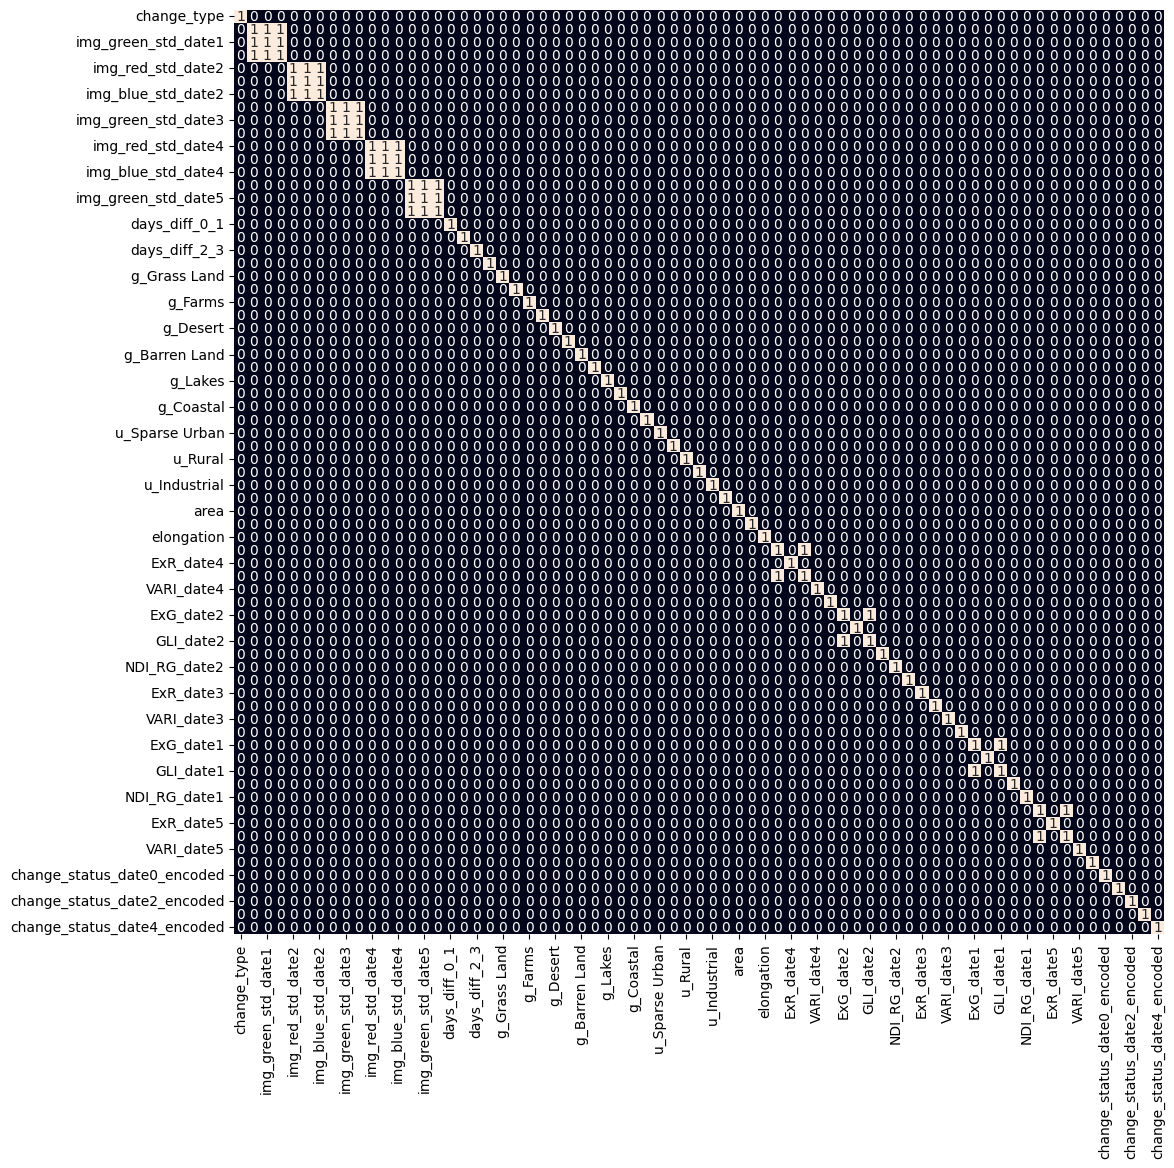

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

"""
Barely any correlation
"""

plt.figure(figsize=(12, 12)) 
sns.heatmap(train_df.corr() > 0.9, annot=True, cbar=False)
plt.show();